In [1]:
from ccpi.framework import ImageData, ImageGeometry
from ccpi.framework import AcquisitionGeometry, AcquisitionData
from ccpi.optimisation.algorithms import CGLS, FISTA
from ccpi.optimisation.functions import Norm2Sq, L1Norm
from ccpi.optimisation.operators import BlockOperator, Gradient, Identity
from ccpi.framework import BlockDataContainer

from ccpi.processors import CenterOfRotationFinder

from ccpi.io import NEXUSDataReader
from ccpi.astra.operators import AstraProjector3DSimple

# All external imports
import numpy
import matplotlib.pyplot as plt
import os
import sys
import scipy
import utilities
from utilities import interactive_slice_display


In [2]:
## Set up a reader object pointing to the Nexus data set. Revise path as needed.
# The data is already  corrected for by flat and dark field.

nexus_file=os.path.join(sys.prefix, 'share','ccpi','24737_fd_normalised.nxs')
myreader = NEXUSDataReader(nexus_file=nexus_file)
data_raw = myreader.load_data()
# Negative logarithm transoform.
data_raw.fill( -numpy.log(data_raw.as_array() ))

In [3]:
print("data shape: ", data_raw.shape)
interactive_slice_display(data_raw, direction=0, auto_range="true")

data shape:  (91, 135, 160)


interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

In [4]:
from ccpi.processors import Resizer

resizer = Resizer(roi=[-1,(1,135),-1])
resizer.set_input(data_raw)
data_cropped = resizer.get_output()

In [5]:
data_cropped.shape

(91, 134, 160)

In [6]:
interactive_slice_display(data_cropped, direction=0, auto_range="true")

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

In [7]:
# Set up CenterOfRotationFinder object to center data.
# Set the output of the normaliser as the input and execute to determine center.
cor = CenterOfRotationFinder()
cor.set_input(data_cropped)
center_of_rotation = cor.get_output()
print( "centre of rotation at pixel: ", center_of_rotation)

centre of rotation at pixel:  86.25


In [8]:
#exercise use the resizer to crop the image 

In [9]:
resizer = Resizer(roi=[-1,-1,(12,160)])
resizer.set_input(data_cropped)
data_centred = resizer.get_output()

In [10]:
interactive_slice_display(data_centred, direction=0, auto_range="true")

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

In [11]:
data_centred.shape

(91, 134, 148)

In [12]:
# Permute array and convert angles to radions for ASTRA
data = data_centred.subset(dimensions=['vertical','angle','horizontal'])
data.geometry = data_centred.geometry
data.geometry.angles = data_centred.geometry.angles*numpy.pi/180.

In [13]:
interactive_slice_display(data, direction=1, auto_range="true")

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

In [14]:
# Create Acquisition and Image Geometries for setting up projector.
ag = data.geometry
ig = ImageGeometry(voxel_num_x=ag.pixel_num_h,
                   voxel_num_y=ag.pixel_num_h, 
                   voxel_num_z=ag.pixel_num_v)
ag.dimension_labels = ['vertical','angle','horizontal']
# Define the projector object
print ("Define projector")
Cop = AstraProjector3DSimple(ig, ag)

Define projector


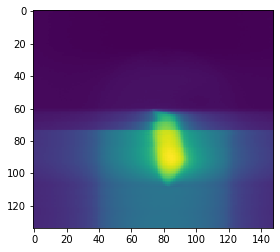

In [15]:
# Test backprojection and projection
z1 = Cop.adjoint(data)
z2 = Cop.direct(z1)

plt.imshow(z1.subset(horizontal_x=68).array)
plt.show()

In [25]:
#define the operator A
L = Gradient(ig)
alpha = 10
operator_block = BlockOperator( Cop, alpha * L, shape=(2,1))

In [26]:
#define the data b
data_block = BlockDataContainer(data, L.range_geometry().allocate())

In [27]:
#setup CGLS
x_init = ig.allocate(0)
cgls = CGLS(x_init=x_init, operator=operator_block, data=data_block)
cgls.max_iteration = 1000
cgls.update_objective_interval = 100

CGLS set_up called from creator


In [28]:
#run the algorithm
cgls.run(100, verbose = True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.01151e+06
       84       1000         0.114          1.73609e+03
Tolerance is reached: 1e-06


In [20]:
x_CGLS_0 = cgls.get_output()
x_CGLS_0_objective = cgls.objective

In [29]:
x_CGLS_reg = cgls.get_output()
x_CGLS_reg_objective = cgls.objective

In [22]:
#output = x_CGLS.as_array()
#f=open("testout.raw","wb")
#output.astype(dtype=numpy.float32).tofile(f)

In [23]:
#print(output.shape)

In [30]:
interactive_slice_display(x_CGLS_0, direction=0, auto_range='false')
interactive_slice_display(x_CGLS_reg, direction=0, auto_range='false')

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=133), Output()), _dom_c…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=133), Output()), _dom_c…

In [ ]:
x_CGLS = x_CGLS_reg
x_CGLS_objective = x_CGLS_reg_objective

In [ ]:
# Fix color and slices for display
v1 = -0.01
v2 = 0.13
hx=80
hy=80
v=68

# Display ortho slices of reconstruction
# Display all reconstructions and decay of objective function
cols = 3
rows = 1
fig = plt.figure()

current = 1
a=fig.add_subplot(rows,cols,current)
a.set_title('horizontal_x')
imgplot = plt.imshow(x_CGLS.subset(horizontal_x=hx).as_array(),vmin=v1,vmax=v2)

current = current + 1
a=fig.add_subplot(rows,cols,current)
a.set_title('horizontal_y')
imgplot = plt.imshow(x_CGLS.subset(horizontal_y=hy).as_array(),vmin=v1,vmax=v2)

current = current + 1
a=fig.add_subplot(rows,cols,current)
a.set_title('vertical')
imgplot = plt.imshow(x_CGLS.subset(vertical=v).as_array(),vmin=v1,vmax=v2)
plt.colorbar()

plt.suptitle('CGLS reconstruction slices')
plt.show()

plt.figure()
plt.semilogy(x_CGLS_objective)
plt.title('CGLS criterion')
plt.show()

In [ ]:
utilities.interactive_slice_display(x_CGLS, direction=0)